In [1]:
import numpy as np
from scipy.integrate import RK45,solve_ivp
from ODE_potentials import VanDerPolePotential,LotkiVolterraPotential
from ODE_samplers import MALA_ODE,ULA_ODE,grad_ascent_ODE,run_eval_test,set_function
from multiprocessing import Pool
import multiprocessing

from baselines import construct_ESVM_kernel
from optimize import optimize_parallel_new
from utils import *

Parameters for van-der-Pole and Lotki-Volterra examples: 

In [2]:
typ = 'LV' #'LV' for Lotki-Volterra, 'VdP' for Van-der-Pole
method = {"sampler":"MALA"} #switch between ULA and MALA
f_type = "posterior_mean"

if typ == 'VdP':
    #true parameter value
    theta_star = 1.0
    #initial coordiante and speed
    y0 = np.array([0.0,2.0],dtype=float)
    #error of measurements
    sigma = 0.5
    #prior variance
    sigma_prior = 0.5
elif typ == 'LV':
    theta_star = np.array([0.6,0.025,0.8,0.025],dtype = float)
    #initial number of victims and predators
    y0 = np.array([30.0,4.0],dtype=float)
    #setting prior parameters
    sigma_prior = np.array([0.5,0.05,0.5,0.05],dtype = float)
    mu_prior = np.array([1.0,0.05,1.0,0.05],dtype=float)
    #measurements error
    sigma = np.array([0.25,0.25])

Timestaps

In [3]:
#initial and last time moments
t0 = 0
t_bound = 10
#moments of observations
t_moments = np.arange(t_bound+1)

Creating potentials

In [4]:
if typ == 'VdP':
    Cur_pot = VanDerPolePotential(sigma,sigma_prior,t_moments,theta_star,y0,t0,t_bound)
elif typ == 'LV':
    Cur_pot = LotkiVolterraPotential(sigma,mu_prior,sigma_prior,t_moments,theta_star,y0,t0,t_bound)

system solved
[[ 37.52358801   5.44451059]
 [ 49.31015054   4.44056815]
 [ 68.02780239   7.49382876]
 [ 96.31994597  69.0224216 ]
 [ 33.96485552 119.57915384]
 [ 11.19476367  55.29111344]
 [  7.28510513  25.46629586]
 [  3.95843583  11.12542133]
 [ 12.06748946   3.71380176]
 [ 12.38341447   6.01556616]
 [ 18.28774199   3.71351383]]


Sampling (currently with MALA)

In [5]:
r_seed = 666
#burn-in period
N_burn = 1*10**3
#Train size
N_train = 1*10**4
#Test size
N_test = 1*10**4
#number of test trajectories
n_traj_test = 100
if typ == 'VdP':
    #dimension
    d = 1
    #step size
    step = 1e-3
elif typ == 'LV':
    #dimension
    d = 4
    #step size
    step = 5e-6

### Construct kernels and sample

In [6]:
# Construct kernel
W_train_spec = construct_ESVM_kernel(N_train)
W_test_spec = construct_ESVM_kernel(N_test)

In [7]:
if typ == 'VdP':
    params_prior = {"sigma":sigma_prior}
elif typ == 'LV':
    params_prior = {"mu":mu_prior,"sigma":sigma_prior}

### Compute starting point (maximum likelihood)

In [8]:
N_steps_ascent = 5000
traj,traj_grad = grad_ascent_ODE(1453,Cur_pot,step,params_prior,N_steps_ascent,d,typ)
theta_mle = traj[-1,:]
print("mle for parameters: ",theta_mle)
Cur_pot.set_mle(theta_mle)

mle for parameters:  [0.6467501  0.02390763 0.81164578 0.02461639]


In [9]:
print(traj_grad[-10:,:])

[[-1.13833387e-11 -6.91553481e-11  3.84270393e-12 -3.46105367e-10]
 [ 9.29567534e-12  3.31183969e-11  1.35491618e-12  2.18646434e-10]
 [ 4.47641924e-13  1.31961997e-10  1.01296749e-11  6.18278762e-11]
 [ 6.33093578e-12 -1.27837296e-10 -1.34767753e-11  1.20023103e-10]
 [-2.34612330e-12  1.04876108e-11 -1.23145938e-12 -3.29087868e-11]
 [-9.93427562e-12 -1.34409817e-10 -1.98419059e-12 -3.41676909e-10]
 [ 5.39390754e-12 -6.26467767e-11 -4.74065232e-12  7.93747290e-11]
 [-4.73221462e-12 -1.19300125e-11  4.52571314e-12 -1.61884728e-10]
 [ 3.11306536e-12  5.95825611e-11  4.97957231e-12  7.58664243e-11]
 [-4.14202006e-12  7.47473194e-11  9.82458559e-12 -8.72883987e-11]]


### Setting function 

In [10]:
if f_type == "posterior_mean":
    inds_arr = np.array([0,1,2,3])
    params = None 
    t_moments = None
    if method["sampler"] == "ULA":
        traj,traj_grad = ULA_ODE(r_seed,Cur_pot, step, params_prior, N_burn, N_train, d, typ)
    elif method["sampler"] == "MALA":
        traj,traj_grad,n_accepted = MALA_ODE(r_seed,Cur_pot, step, params_prior, N_burn, N_train, d, typ)
        print("n_accepted = ",n_accepted)
    traj = traj[np.newaxis,:]
    traj_grad = traj_grad[np.newaxis,:]
    f_vals = set_function(f_type,traj,inds_arr,params)
    print(f_vals.shape)
elif f_type == "evidence":
    #time moments for numeric integrations
    n_points = 10.0
    f_vals = np.zeros((1+int(n_points),N_train,1),dtype = float)
    traj = np.zeros((1+int(n_points),N_train,d),dtype = float)
    traj_grad = np.zeros((1+int(n_points),N_train,d),dtype = float)
    t_moments = (np.arange(n_points+1)/n_points)**5
    print(t_moments)
    for i in range(len(t_moments)):
        if method["sampler"] == "ULA":
            f_vals[i],traj[i],traj_grad[i] = ULA_ODE(r_seed+i,Cur_pot, step, params_prior, N_burn, N_train, d, typ,t_moments[i])
        elif method["sampler"] == "MALA":
            f_vals[i],traj[i],traj_grad[i],n_accepted = MALA_ODE(r_seed+i,Cur_pot,step,params_prior,N_burn,N_train,d,typ,t_moments[i])
            print("n_accepted = ",n_accepted)           

n_accepted =  7982
(1, 10000, 4)


### Training coefficients for EVM, ESVM and LS

In [11]:
n_restarts = 2 # Number of restarts during optimization
sigma_optim = 1.0 # Deviation of starting points
tol = 1e-6 # Tolerance (for the norm of gradient)
degree = 1 #degree of polynomails
inds_arr = np.array([0,1,2,3])

In [12]:
if f_type == "posterior_mean":
    A_ESVM_k,A_EVM_k,A_LS_k = optimize_parallel_new(degree,inds_arr,f_vals,traj,traj_grad,W_train_spec,n_restarts,tol,sigma_optim)
    A_ESVM_2,A_EVM_2,A_LS_2 = optimize_parallel_new(2,inds_arr,f_vals,traj,traj_grad,W_train_spec,n_restarts,tol,sigma_optim)
elif f_type == "evidence":
    A_ESVM_k = []
    A_EVM_k = []
    A_LS_k = []
    A_ESVM_2 = []
    A_EVM_2 = []
    A_LS_2 = []
    for i in range(len(t_moments)):
        A_ESVM_k_cur,A_EVM_k_cur,A_LS_k_cur = optimize_parallel_new(degree,inds_arr,f_vals[np.newaxis,i],\
            traj[np.newaxis,i],traj_grad[np.newaxis,i],W_train_spec,n_restarts,tol,sigma_optim)
        A_ESVM_2_cur,A_EVM_2_cur,A_LS_2_cur = optimize_parallel_new(2,inds_arr,f_vals[np.newaxis,i],\
            traj[np.newaxis,i],traj_grad[np.newaxis,i],W_train_spec,n_restarts,tol,sigma_optim)
        A_ESVM_k.append(A_ESVM_k_cur)
        A_EVM_k.append(A_EVM_k_cur)
        A_LS_k.append(A_LS_k_cur)
        A_ESVM_2.append(A_ESVM_2_cur)
        A_EVM_2.append(A_EVM_2_cur)
        A_LS_2.append(A_LS_2_cur)

1 degree optimization terminated succesfully
1 degree optimization terminated succesfully
1 degree optimization terminated succesfully
jacobian at termination: 
jacobian at termination: 
jacobian at termination: 
1 degree optimization terminated succesfully
[ 1.24948112e-15 -3.91406079e-15  4.91855781e-16  2.36918640e-14]
jacobian at termination: 
[ 7.03765127e-10  3.30069531e-10  1.61706881e-09 -2.06894187e-08]
[-6.64967964e-16 -4.51373001e-16  1.90870588e-16 -1.62178501e-14]
1 degree optimization terminated succesfully
[ 2.80331314e-15  2.93098879e-14 -3.33066907e-16 -6.03961325e-14]
jacobian at termination: 
1 degree optimization terminated succesfully
1 degree optimization terminated succesfully
[-6.82397433e-16  2.27118832e-16  2.32007077e-16 -1.74091942e-14]
jacobian at termination: 
jacobian at termination: 
[ 1.17683641e-14  7.72715225e-14 -6.43929354e-15  7.72715225e-14]
[-6.24500451e-16  1.88737914e-15 -2.32452946e-16 -2.31759056e-14]
1 degree optimization terminated succesfu

### Run test simulations

In [13]:
# Create a dictionary, put respective matrices into it
params = None
if f_type == "posterior_mean":
    CV_dict = {"ESVM":[A_ESVM_k,A_ESVM_2],"ZV":[A_EVM_k,A_EVM_2],"LS":[A_LS_k,A_LS_2]}
elif f_type == "evidence":
    CV_dict = [{"ESVM":[A_ESVM_k[i],A_ESVM_2[i]],"ZV":[A_EVM_k[i],A_EVM_2[i]],"LS":[A_LS_k[i],A_LS_2[i]]} for i in range(len(t_moments))]
# Number of cores exploited for the computation of the independent trajectories
# by deault, all available cores on the machine
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(run_eval_test, [(i,method,inds_arr,Cur_pot,W_test_spec,CV_dict,step,N_burn,N_test,d,params,f_type,params_prior,typ,t_moments) for i in range (n_traj_test)])
trav.close()
res_arr = np.asarray(res) # Saving results as np.array

### Results

In [14]:
print("Estimators")
print("Vanilla MC {}".format(np.mean(res_arr[:,0,0,:],axis=0)))
print("ESVM pol=1 {}".format(np.mean(res_arr[:,0,1,:],axis=0)))
print("ESVM pol=2 {}".format(np.mean(res_arr[:,0,2,:],axis=0)))
print("EVM pol=1 {}".format(np.mean(res_arr[:,0,3,:],axis=0)))
print("EVM pol=2 {}".format(np.mean(res_arr[:,0,4,:],axis=0)))
print("LS pol=1 {}".format(np.mean(res_arr[:,0,5,:],axis=0)))
print("LS pol=2 {}".format(np.mean(res_arr[:,0,6,:],axis=0)))

Estimators
Vanilla MC [0.64015392 0.02425484 0.81814863 0.02519806]
ESVM pol=1 [0.64105486 0.02407095 0.82202153 0.02519821]
ESVM pol=2 [0.64316112 0.02423679 0.81939242 0.0250723 ]
EVM pol=1 [0.64173953 0.02412456 0.8211498  0.02516254]
EVM pol=2 [0.64315218 0.02423358 0.8194335  0.02507348]
LS pol=1 [0.63726117 0.02395714 0.81541052 0.02498691]
LS pol=2 [0.64098589 0.02415208 0.81667428 0.02498908]


In [15]:
print("Variances")
print("Vanilla MC {}".format(np.mean(res_arr[:,1,0,:],axis=0)))
print("ZAV pol=1 {}".format(np.mean(res_arr[:,1,1,:],axis=0)))
print("ZAV pol=2 {}".format(np.mean(res_arr[:,1,2,:],axis=0)))
print("ZV pol=1 {}".format(np.mean(res_arr[:,1,3,:],axis=0)))
print("ZV pol=2 {}".format(np.mean(res_arr[:,1,4,:],axis=0)))
print("LS pol=1 {}".format(np.mean(res_arr[:,1,5,:],axis=0)))
print("LS pol=2 {}".format(np.mean(res_arr[:,1,6,:],axis=0)))

Variances
Vanilla MC [0.21907132 0.00077401 0.25632556 0.00061962]
ZAV pol=1 [1.40909430e-02 8.13760347e-05 3.02440570e-02 5.53294225e-05]
ZAV pol=2 [2.00339668e-04 1.56858872e-06 7.32304270e-04 1.16110067e-06]
ZV pol=1 [3.09601617e-02 1.73057715e-04 4.93039985e-02 9.89038648e-05]
ZV pol=2 [2.52258867e-04 2.95520901e-06 7.84880844e-04 1.29856495e-06]
LS pol=1 [3.09069390e-01 6.63994936e-04 2.43637374e-01 2.14819339e-04]
LS pol=2 [5.53185271e+00 8.00122828e-03 8.96121277e+00 8.41705585e-03]


In [16]:
#saving the results
np.save("Results/10_07/ODE_LV_MALA_gamma_5e-6_bn_20_burn_1e-3_train_1e4_test_1e4_atol_-3_rtol_-3_traj_100_t_10_sigma_025_all.npy",res_arr)

In [ ]:
res_arr = np.load("Results/09_07/ODE_VdP_MALA_gamma_1e-3_bn_10_burn_100_train_1000_test_1000_atol_-5_rtol_-3_y0_2_traj_100_t_10_k_3.npy")

### Plotting the results

In [23]:
var_ind = 3 # Index to plot
title = ""
labels = ['EVM','ESVM']
#labels = ['Vanilla','EVM','ESVM']

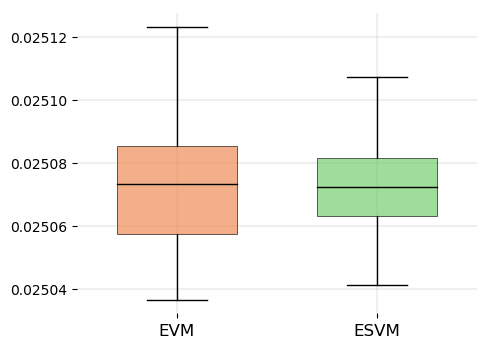

In [24]:
data = [res_arr[:,0,4,var_ind],res_arr[:,0,2,var_ind]] 
#data = [res_arr[:,0,0,var_ind],res_arr[:,0,3,var_ind],res_arr[:,0,1,var_ind]] 
boxplot_ind(data, title, labels)

In [26]:
var_ind = 1 # Index to plot
title = ""
labels = ['Vanilla','EVM','ESVM']

In [ ]:
data = [res_arr[:,0,0,var_ind],res_arr[:,0,4,var_ind],res_arr[:,0,2,var_ind]] 
boxplot_ind(data, title, labels)

In [28]:
var_ind = 1
vars_vanilla = res_arr[:,1,0,var_ind]
vars_esvm_1st = res_arr[:,1,1,var_ind]
vars_esvm_2nd = res_arr[:,1,2,var_ind]
vars_evm_1st = res_arr[:,1,3,var_ind]
vars_evm_2nd = res_arr[:,1,4,var_ind]
print("average VRF for 1st order EVM:",np.mean(vars_vanilla/vars_evm_1st))
print("average VRF for 2nd order EVM:",np.mean(vars_vanilla/vars_evm_2nd))
print("average VRF for 1st order ESVM:",np.mean(vars_vanilla/vars_esvm_1st))
print("average VRF for 2nd order ESVM:",np.mean(vars_vanilla/vars_esvm_2nd))

average VRF for 1st order EVM: 4.655479086169268
average VRF for 2nd order EVM: 351.53982654039254
average VRF for 1st order ESVM: 10.04621818599417
average VRF for 2nd order ESVM: 644.5088275173703
